In [1]:
import sys
sys.path.append('../')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


import tensorflow as tf
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import numpy as np
import keras
from machine_learning.models import DistributedProduction
from data_processing.batch_generator import load_test_set

In [3]:
# MODEL
model = DistributedProduction()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.TruePositives(), 
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(), 
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()])

In [4]:
# DATA
test_labels = np.load(f'data/test/all_transaction_labels.npy').astype(float)
test_set = tf.data.Dataset.from_tensor_slices(
    (np.load(f'data/test/transactions.npy'), 
     test_labels)
).batch(1)
sample_transaction = np.load(f'data/test/transactions.npy')[0]

In [5]:
model(np.expand_dims(sample_transaction, axis=0))


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49172541]], dtype=float32)>

In [6]:
class randomizer(keras.callbacks.Callback):
    def on_test_batch_end(self, batch, logs=None):
        self.model.category_gru.shared_states.assign(
            tf.random.uniform(
                self.model.category_gru.shared_states.shape,
                minval=-1,
                maxval=1,
            ))

callback = randomizer()
callback.set_model(model)

In [8]:
model.load_weights(f'machine_learning/saved_models/double_{17}.keras')
results = model.evaluate(test_set, return_dict=True, callbacks=callback)

     1/555719 [..............................] - ETA: 1:37:45 - loss: 0.0031 - binary_accuracy: 1.0000 - true_positives: 0.0000e+00 - true_negatives: 1.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00WARNING:tensorflow:Callback method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_test_batch_end` time: 0.0015s). Check your callbacks.


   212/555719 [..............................] - ETA: 17:49 - loss: 0.0343 - binary_accuracy: 0.9906 - true_positives: 0.0000e+00 - true_negatives: 210.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00  

KeyboardInterrupt: 

In [ ]:
y_pred_proba = model.predict(test_set, callbacks=callback)

555719/555719 [==============================] - 382s 687us/step


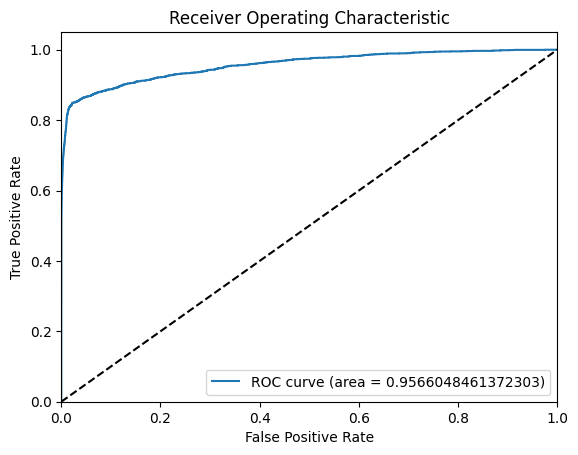

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate FPR, TPR, and thresholds using NumPy
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate AUC using scikit-learn
auc_score = auc(fpr, tpr)

# Plot ROC curve using Matplotlib
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
